# TDA - Ground Truth

- Gabriel Wendell Celestino Rocha
---

### 0. Imports and path setup

In [13]:
import sys, os 
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../"))
from src.tda.spatial_embedding import spatial_delay_embedding
from src.tda.persistence_tools import (
    compute_vr_persistence,
    betti_curves_from_diagrams,
    persistence_landscape,
)

# Make plots nicer
import smplotlib
def opt_plot_axs(ax):
    ax.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 15
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
def opt_plot():
    plt.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 15
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)

### Load the dataset

In [2]:
DATA_DIR = "../data/processed/"
data = np.load(DATA_DIR + "brio_wu_tensors.npz")

times    = data["times"]       # (N_t,)
x        = data["x"]           # (N_x,)
rho_norm = data["rho_norm"]    # (N_t, N_x)
p_norm   = data["p_norm"]      # (N_t, N_x)

N_t, N_x = rho_norm.shape
print("N_t, N_x =", N_t, N_x)

N_t, N_x = 41 1000


---

### 1. Choose Representative Times

Let's pick four times:
- $t\approx0.00$ (initial step);
- $t\approx0.25$ (early evolution);
- $t\approx0.75$ (strong interactions);
- $t\approx1.50$ (large stage);

In [3]:
t_samples = [0.00, 0.25, 0.75, 1.50]
idx_samples = [int(np.argmin(np.abs(times - t))) for t in t_samples]

for t, idx in zip(t_samples, idx_samples):
    print(f"Requested t = {t:.2f}, nearest times[{idx}] = {times[idx]:.2f}")

Requested t = 0.00, nearest times[0] = 0.00
Requested t = 0.25, nearest times[5] = 0.25
Requested t = 0.75, nearest times[15] = 0.75
Requested t = 1.50, nearest times[30] = 1.50


We’ll use density for exploration first.

### 2. Parameter Grid and Betti Curve Exploration

Define candidate embedding parameters and a radius grid

In [4]:
m_values   = [3, 4, 5, 6]
tau_values = [1, 2, 4]
stride     = 2            # Subsample to speed up

# Radius grid for Betti curves:
# We can estimate a reasonable max radius from pairwise distances between
# points in an example embedding.

# Take one example embedding (m = 5, tau = 2) at t = 0.75
example_field = rho_norm[idx_samples[2]]   # Density at ~0.75
example_pc = spatial_delay_embedding(example_field, m = 5, tau = 2, 
                                     stride = stride)
# Rough scale: typical inter-point distances
dists = np.linalg.norm(example_pc[None,:,:] - example_pc[:,None,:], axis = -1)
max_dist = np.percentile(dists, 99)   # Robust upper bound
print("Estimated max distance ≈", max_dist)

n_radii = 100
radii = np.linspace(0.0, max_dist, n_radii)

Estimated max distance ≈ 5.715272353132583


Now loop over a few $(m,\tau)$ and plot Betti curves.

=== m = 3, tau = 1 ===


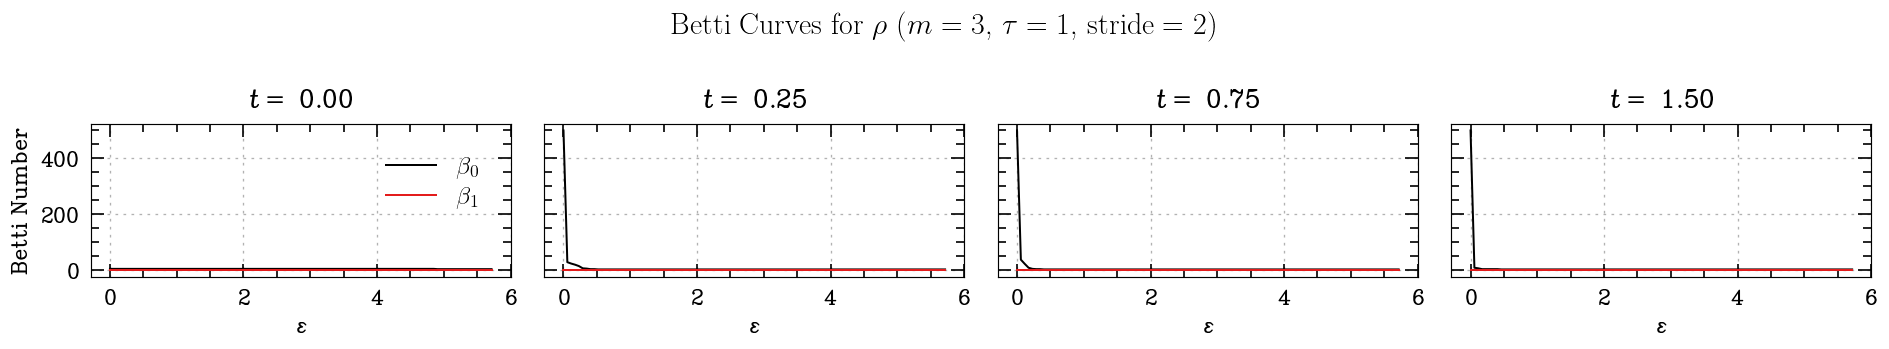

=== m = 3, tau = 2 ===


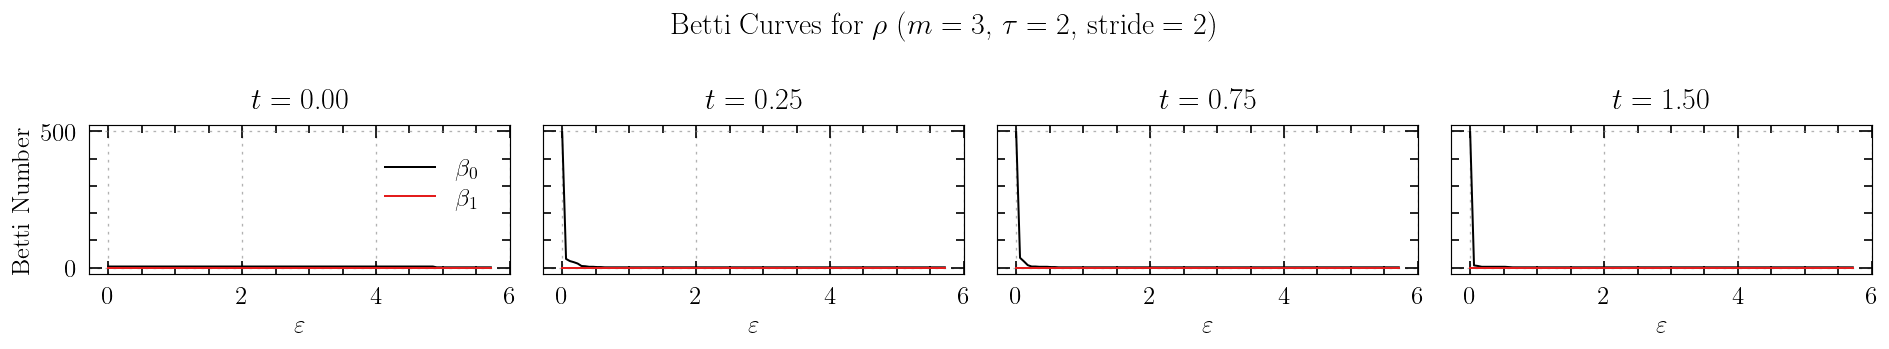

=== m = 3, tau = 4 ===


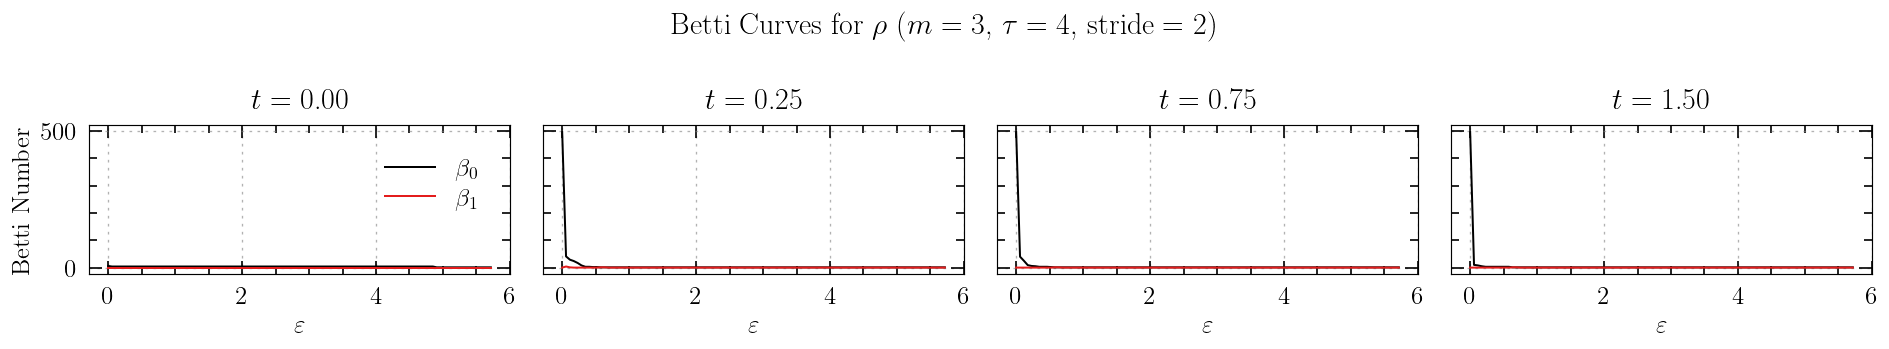

=== m = 4, tau = 1 ===


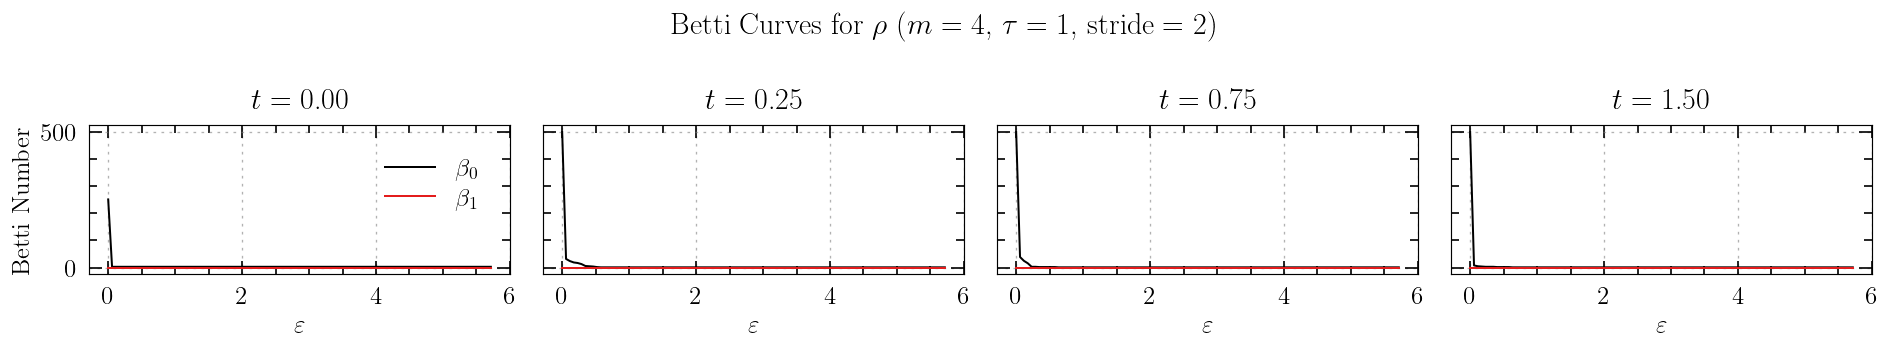

=== m = 4, tau = 2 ===


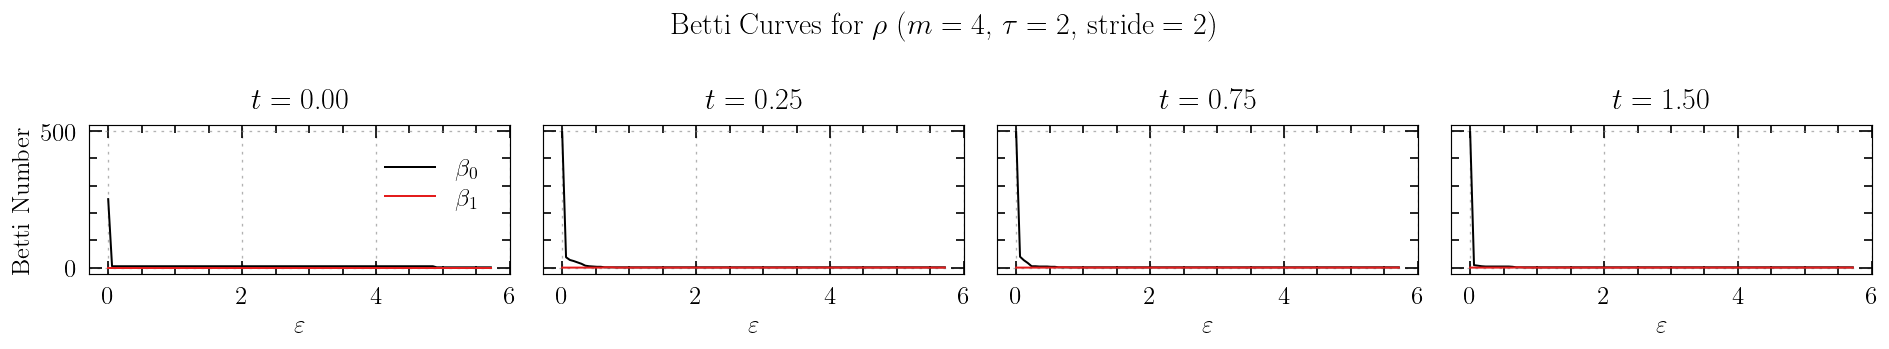

=== m = 4, tau = 4 ===


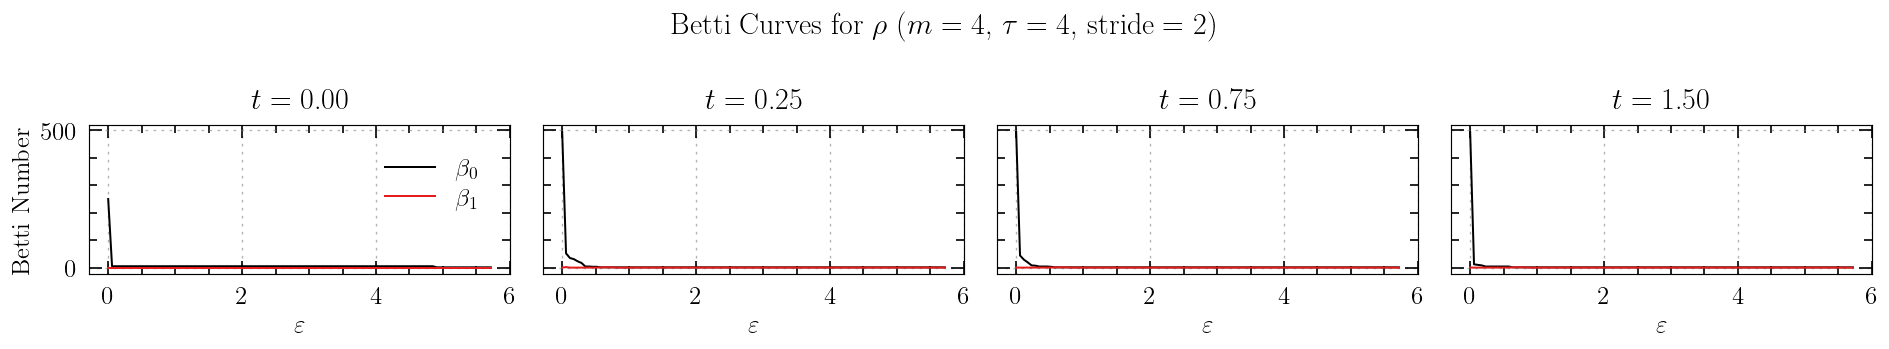

=== m = 5, tau = 1 ===


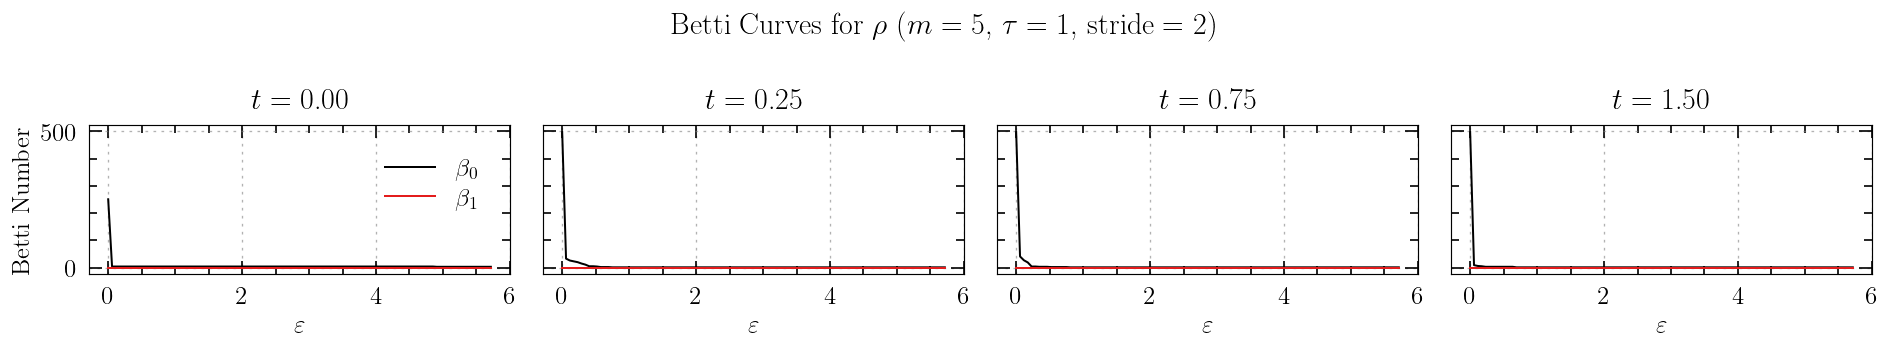

=== m = 5, tau = 2 ===


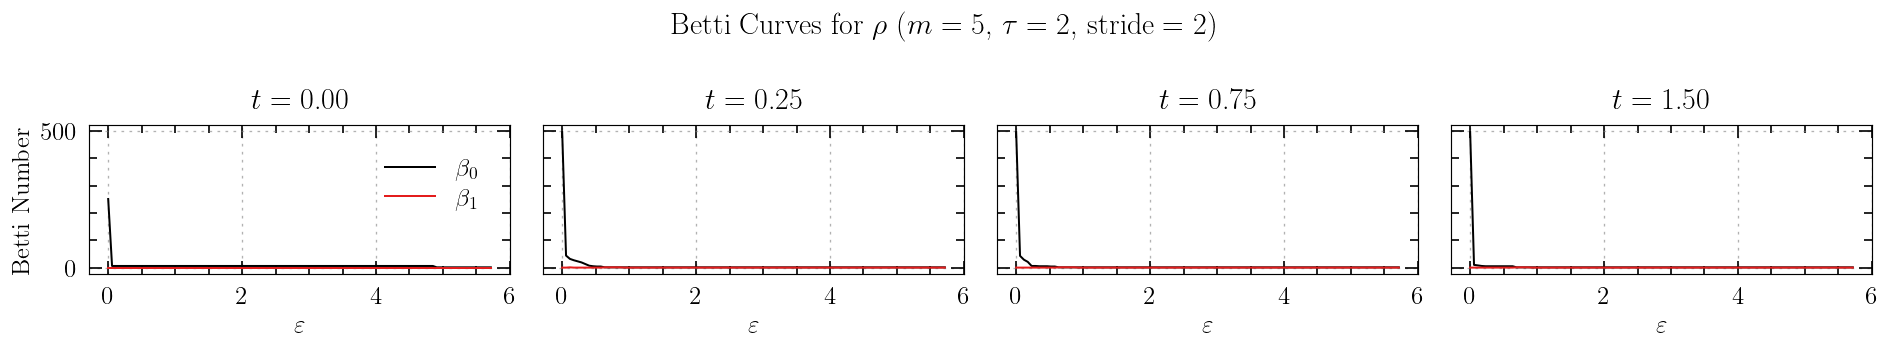

=== m = 5, tau = 4 ===


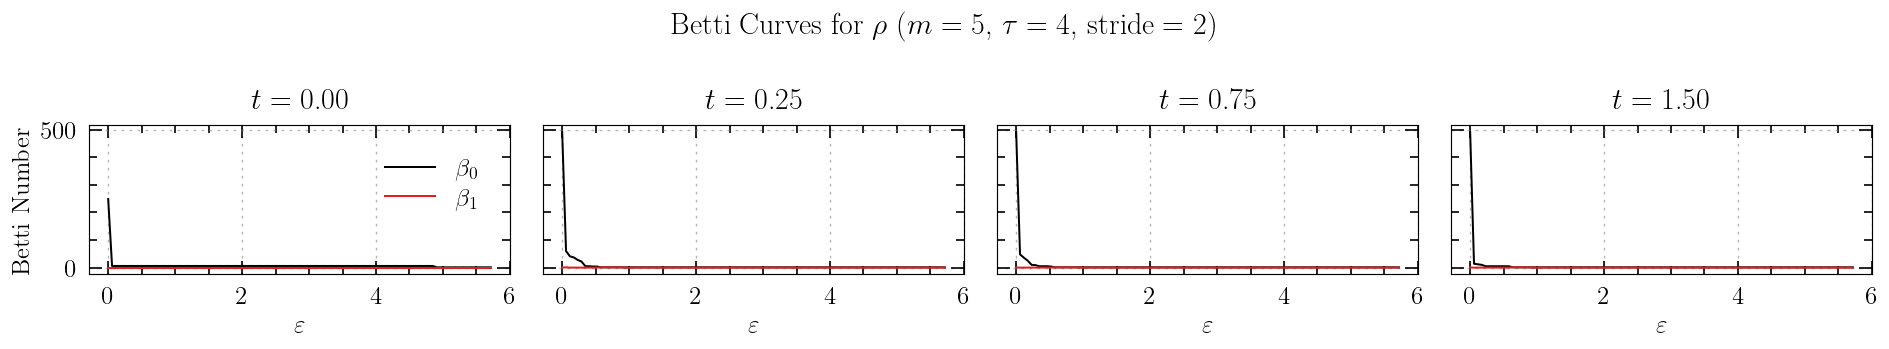

=== m = 6, tau = 1 ===


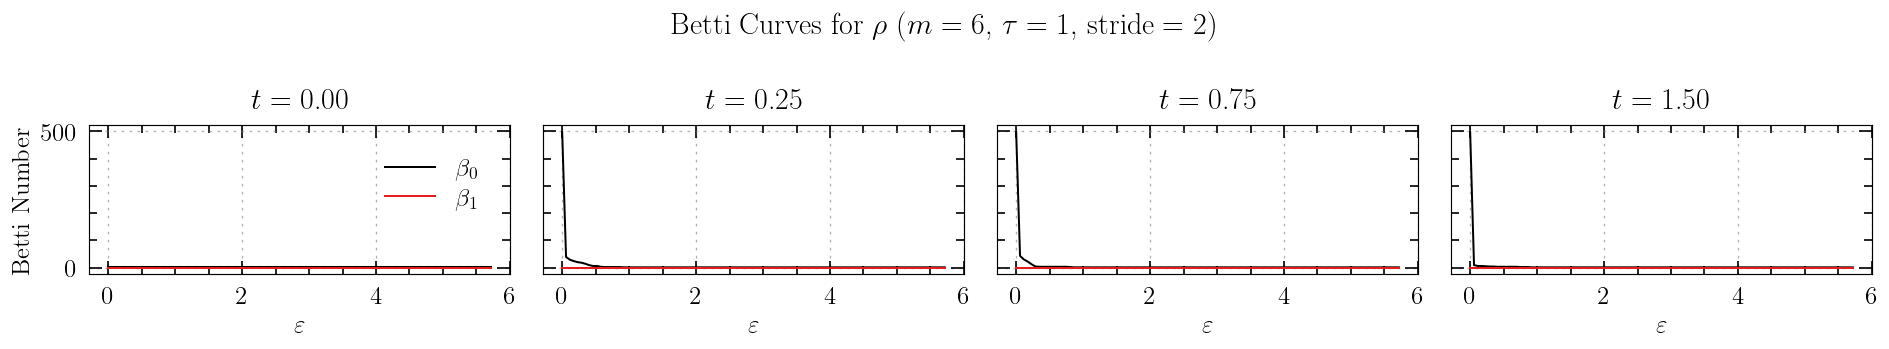

=== m = 6, tau = 2 ===


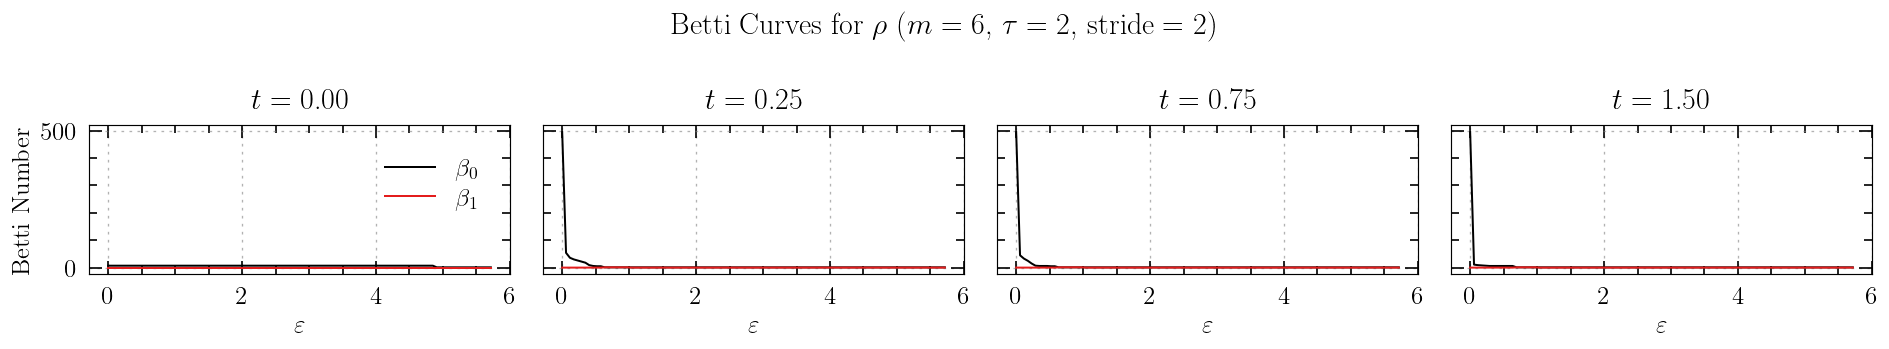

=== m = 6, tau = 4 ===


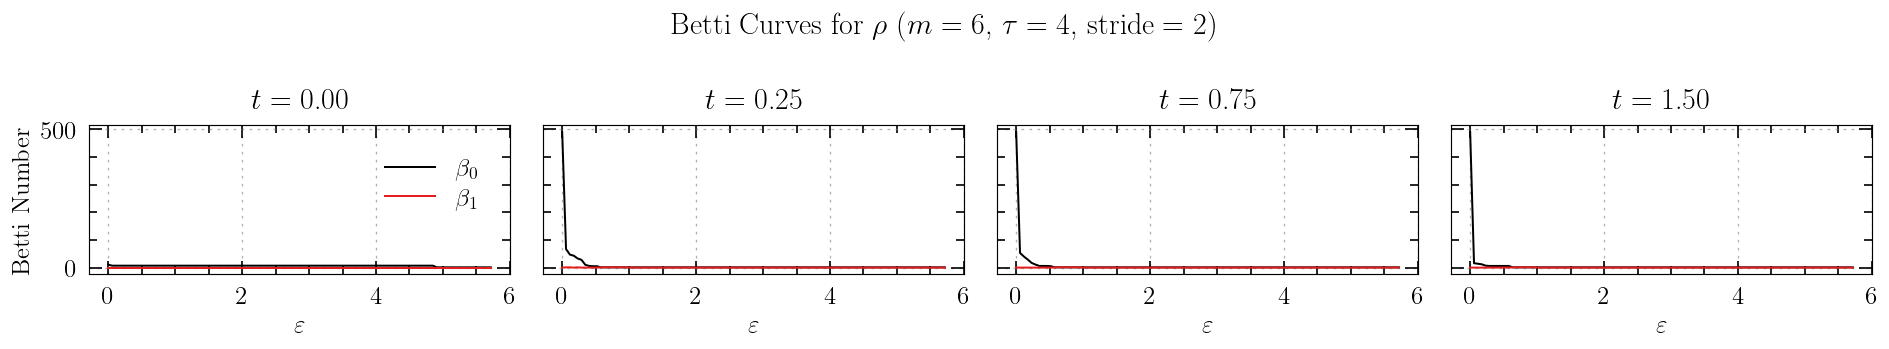

In [5]:
def plot_betti_for_params(m, tau, dim = 1):
    fig, axes = plt.subplots(1, len(idx_samples), figsize = (4*len(idx_samples), 3), sharey=True)
    if len(idx_samples) == 1:
        axes = [axes]

    for ax, k, t_req in zip(axes, idx_samples, t_samples):
        field = rho_norm[k]  # ρ(x, t_k)

        pc = spatial_delay_embedding(field, m = m, tau = tau, 
                                     stride = stride, normalize = "none")
        diagrams = compute_vr_persistence(pc, maxdim = dim)
        betti_dict = betti_curves_from_diagrams(diagrams, radii, maxdim = dim)

        beta0 = betti_dict[0]
        if dim >= 1:
            beta1 = betti_dict[1]
        else:
            beta1 = None

        ax.plot(radii, beta0, label = r"$\beta_0$")
        if beta1 is not None:
            ax.plot(radii, beta1, label = r"$\beta_1$")
        ax.set_title(f"$t=$ {times[k]:.2f}")
        ax.set_xlabel(r"$\varepsilon$")
        opt_plot_axs(ax)

    axes[0].set_ylabel("Betti Number")
    axes[0].legend(loc = "best")
    fig.suptitle(f"Betti Curves for $\\rho$ ($m=$ {m}, $\\tau=$ {tau}, stride = {stride})")
    plt.tight_layout()
    plt.show()
    
# Then try several parameters:
for m in m_values:
    for tau in tau_values:
        print(f"=== m = {m}, tau = {tau} ===")
        plot_betti_for_params(m, tau, dim = 1)

After inspecting, pick a “good” choice, say (you can change these based on what you observ): 

In [6]:
m_star = 5
tau_star = 2

### 4. Visualizing a Few Persistence Diagrams

To have nice figures for the event, plot some PDs:

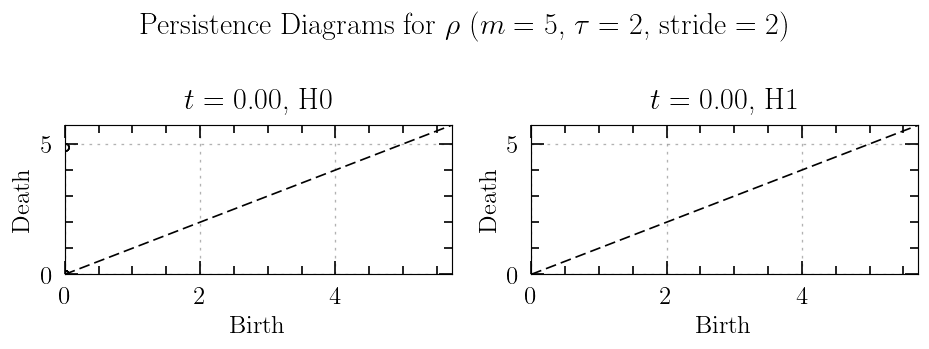

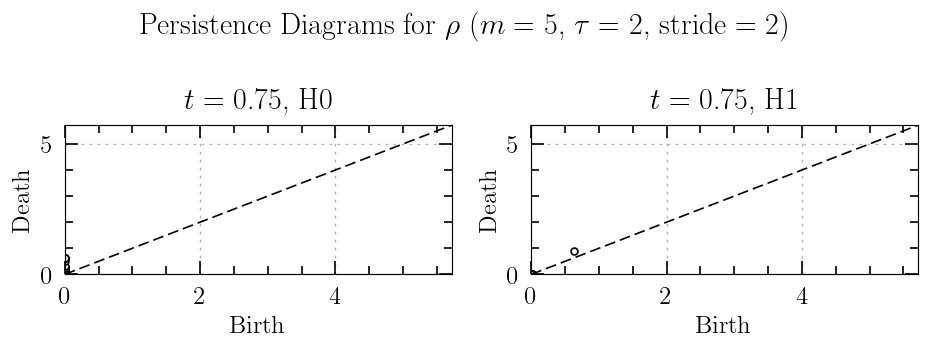

In [7]:
def plot_diagrams_for_time(k, m, tau, dim = 1):
    field = rho_norm[k]
    pc = spatial_delay_embedding(field, m = m, tau = tau, stride = stride)
    diagrams = compute_vr_persistence(pc, maxdim = dim)

    fig, axes = plt.subplots(1, dim+1, figsize = (4*(dim+1), 3))
    if dim == 0:
        axes = [axes]

    for d in range(dim+1):
        diag = diagrams[d]
        ax = axes[d]
        if diag.size > 0:
            ax.scatter(diag[:,0], diag[:,1], s = 17, color = 'w', ec = 'k')
        ax.plot([0, radii[-1]], [0, radii[-1]], "k--", lw = 1)
        ax.set_xlabel("Birth")
        ax.set_ylabel("Death")
        ax.set_title(f"$t=$ {times[k]:.2f}, H{d}")
        ax.set_xlim(0, radii[-1])
        ax.set_ylim(0, radii[-1])
        opt_plot_axs(ax)

    plt.suptitle(f"Persistence Diagrams for $\\rho$ ($m=$ {m}, $\\tau=$ {tau}, stride = {stride})")
    plt.tight_layout()
    plt.show()

# Example for early and mid times:
plot_diagrams_for_time(idx_samples[0], m_star, tau_star, dim = 1)
plot_diagrams_for_time(idx_samples[2], m_star, tau_star, dim = 1)

## 5. Time-resolved TDA Features

Now that we’ve chosen $(m^{*},\tau^{*})$, we compute Betti curves over all time steps.

### 5.1 Compute Betti Curves for All Times (Density)

In [8]:
m_star  = 5   # Set based on exploration
tau_star = 2
stride   = 2

n_radii = 100
# Reuse radii if you’re happy with it; otherwise recompute based on a few embeddings
# Radii already defined above; ensure it's available here.

betti0_rho = np.zeros((N_t, n_radii), dtype = int)
betti1_rho = np.zeros((N_t, n_radii), dtype = int)

for k in range(N_t):
    field = rho_norm[k]
    pc = spatial_delay_embedding(field, m = m_star, tau = tau_star, 
                                 stride = stride)
    diagrams = compute_vr_persistence(pc, maxdim = 1)
    betti_dict = betti_curves_from_diagrams(diagrams, radii, maxdim = 1)
    betti0_rho[k, :] = betti_dict[0]
    betti1_rho[k, :] = betti_dict[1]

print("betti0_rho shape:", betti0_rho.shape)
print("betti1_rho shape:", betti1_rho.shape)

betti0_rho shape: (41, 100)
betti1_rho shape: (41, 100)


### 5.2 Landscapes over time

In [9]:
n_layers = 3
landscapes_rho_H1 = np.zeros((N_t, n_layers, n_radii), dtype = float)

for k in range(N_t):
    field = rho_norm[k]
    pc = spatial_delay_embedding(field, m = m_star, tau = tau_star, 
                                 stride = stride)
    diagrams = compute_vr_persistence(pc, maxdim = 1)
    diag_H1 = diagrams[1]
    L = persistence_landscape(diag_H1, radii, n_layers = n_layers)
    landscapes_rho_H1[k, :, :] = L

print("Landscapes_rho_H1 shape:", landscapes_rho_H1.shape)

Landscapes_rho_H1 shape: (41, 3, 100)


### 5.3 Save TDA Features to Disk

In [11]:
tda_dir = "../results/tda"
os.makedirs(tda_dir, exist_ok = True)

np.savez_compressed(
    os.path.join(tda_dir, "betti_curves_density_m%d_tau%d.npz" % (m_star, tau_star)),
    times = times,
    radii = radii,
    betti0 = betti0_rho,
    betti1 = betti1_rho,
)

# Landscapes 
np.savez_compressed(
    os.path.join(tda_dir, "landscapes_density_H1_m%d_tau%d.npz" % (m_star, tau_star)),
    times = times,
    radii = radii,
    landscapes = landscapes_rho_H1,
)

### 5.4 Visual Analysis: Betti Heatmaps

Plot Betti curves as $x-t$ heatmaps

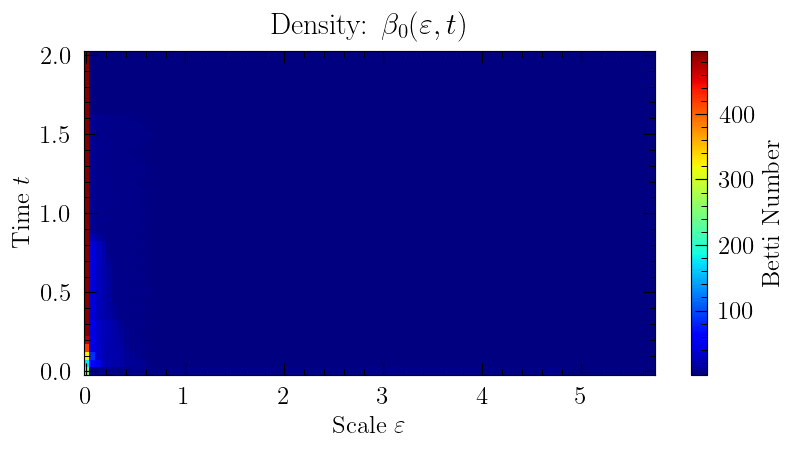

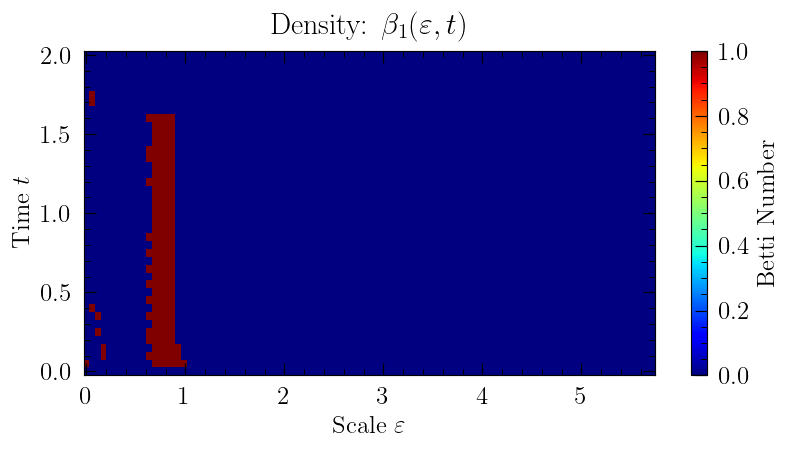

In [15]:
def plot_betti_heatmap(times, radii, betti, title = ""):
    """
    betti: array shape (N_t, N_r)
    """
    T, R = betti.shape
    Tgrid, Rgrid = np.meshgrid(times, radii, indexing = "ij")

    plt.figure(figsize = (7, 4))
    pcm = plt.pcolormesh(
        Rgrid, Tgrid, betti, shading = "auto", cmap = "jet"
    )
    plt.colorbar(pcm, label = "Betti Number")
    plt.xlabel(r"Scale $\varepsilon$")
    plt.ylabel("Time $t$")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_betti_heatmap(times, radii, betti0_rho,
                   title = r"Density: $\beta_0(\varepsilon, t)$")

plot_betti_heatmap(times, radii, betti1_rho,
                   title = r"Density: $\beta_1(\varepsilon, t)$")

In these plots we should see:
- Regions in $(t,\varepsilon)$ where shocks / contacts appear as peaks in $\beta_{1}$.
- Rarefaction waves potentially changing $\beta_{0}$ structure.

### 5.5 Repeat for Pressure

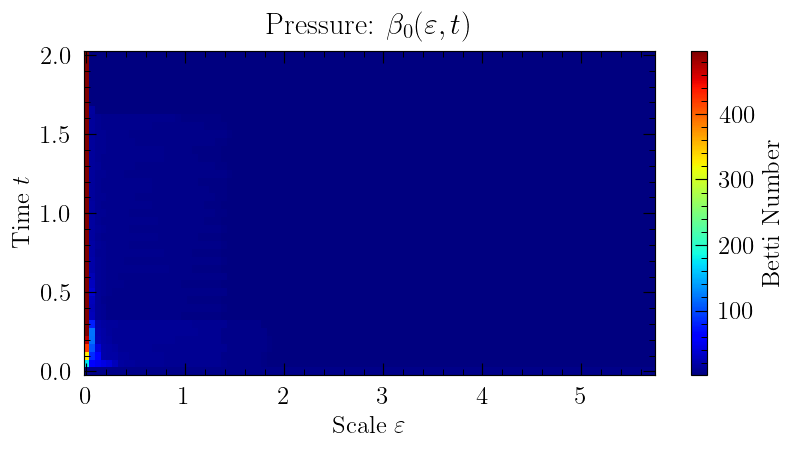

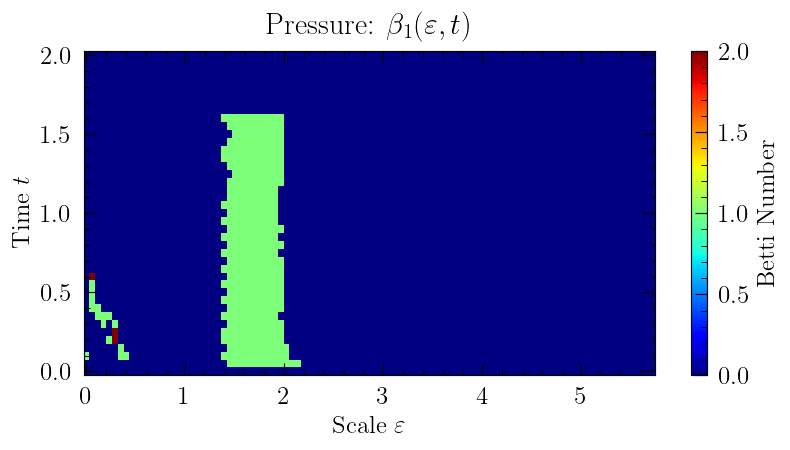

In [16]:
betti0_p = np.zeros((N_t, n_radii), dtype = int)
betti1_p = np.zeros((N_t, n_radii), dtype = int)

for k in range(N_t):
    field = p_norm[k]
    pc = spatial_delay_embedding(field, m = m_star, tau = tau_star, 
                                 stride = stride)
    diagrams = compute_vr_persistence(pc, maxdim = 1)
    betti_dict = betti_curves_from_diagrams(diagrams, radii, maxdim = 1)
    betti0_p[k, :] = betti_dict[0]
    betti1_p[k, :] = betti_dict[1]

np.savez_compressed(
    os.path.join(tda_dir, "betti_curves_pressure_m%d_tau%d.npz" % (m_star, tau_star)),
    times = times,
    radii = radii,
    betti0 = betti0_p,
    betti1 = betti1_p,
)

plot_betti_heatmap(times, radii, betti0_p,
                   title = r"Pressure: $\beta_0(\varepsilon, t)$")

plot_betti_heatmap(times, radii, betti1_p,
                   title = r"Pressure: $\beta_1(\varepsilon, t)$")

---